In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from numpy.linalg import inv
import scienceplots
import warnings

warnings.filterwarnings("ignore")

plt.style.use(['bmh','science','notebook','grid'])

In [3]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [5]:
import os

usb_home = "J:/Universidade/IC"
usb_uff = "F:/Universidade/IC"

if os.path.exists(usb_home + "/Amplitude/amplitude_synth.npy"):
    data_amp = np.load(usb_home + "/Amplitude/amplitude_synth.npy")
else:
    data_amp = np.load(usb_uff + "/Amplitude/amplitude_synth.npy")

if os.path.exists(usb_home + "/Faults/fault_synth.npy"):
    data_faults = np.load(usb_home + "/Faults/fault_synth.npy")
else:
    data_faults = np.load(usb_uff + "/Faults/fault_synth.npy")

if os.path.exists(usb_home + "/Impedance/impedance_synth.npy"):
    data_imp = np.load(usb_home + "/Impedance/impedance_synth.npy")
else:
    data_imp = np.load(usb_uff + "/Impedance/impedance_synth.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_faults)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [7]:
# Impedância de baixa
TEXT_COLOR = "#212121"
cutoff_back = 6
cutoff_30hz = 30
fs = 128

imp_30hz = butter_lowpass_filtfilt(data_imp, cutoff_30hz, fs, order=5)
imp_background = butter_lowpass_filtfilt(data_imp, cutoff_back, fs, order=5)

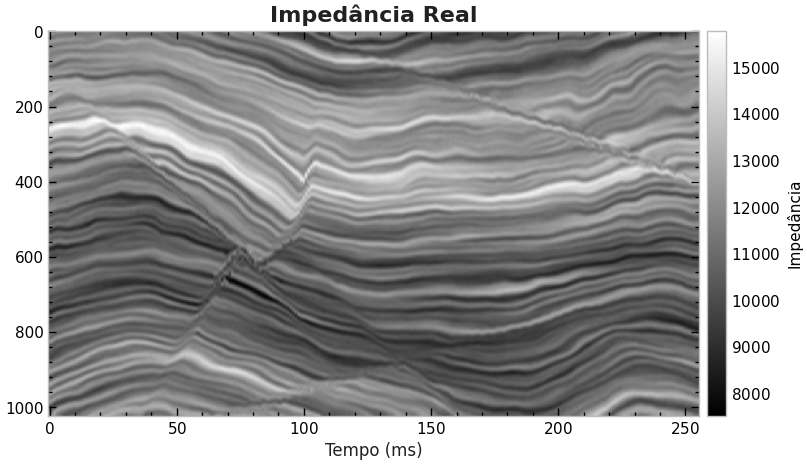

In [8]:
plt.figure(figsize=(10, 5))

impb = plt.imshow(imp_30hz[:, 128, :].T, cmap='gray', aspect='auto')
plt.title('Impedância Real', fontsize=16, fontweight='bold', color=TEXT_COLOR)
plt.xlabel("Tempo (ms)", fontsize=12, color=TEXT_COLOR)
plt.gca().set_yticklabels([str(int(tick)*4) for tick in plt.gca().get_yticks()])
cbar = plt.colorbar(impb, pad=0.01)
cbar.set_label('Impedância', size=11)
cbar.ax.tick_params(labelsize=11)
plt.tick_params(axis='both', labelsize=11)

plt.grid()
plt.show()

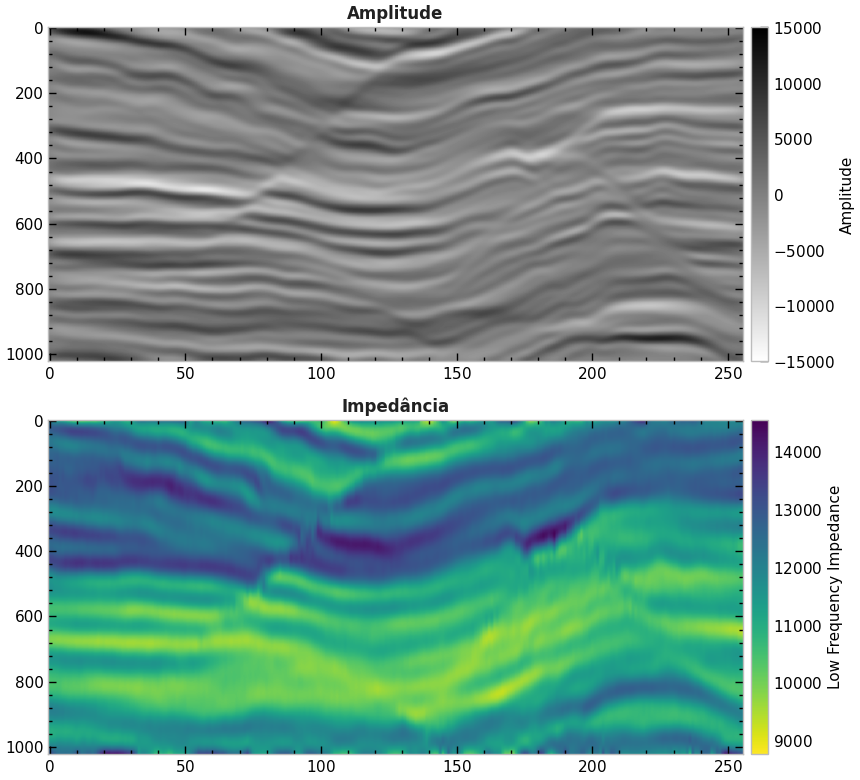

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(9,8))

c = axs[0].imshow(data_amp[128,:,:].T,
           cmap='gray_r',
           aspect='auto',
           vmin=-15000,
           vmax=15000)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label('Amplitude', size=11)
cbar.ax.tick_params(labelsize=11)
axs[0].set_title('Amplitude', fontsize=12, fontweight='bold', color=TEXT_COLOR)
axs[0].set_yticklabels([str(int(tick)*4) for tick in axs[0].get_yticks()])  # Altera os rótulos do eixo y
axs[0].tick_params(axis='both', labelsize=11)
axs[0].grid(False)

c = axs[1].imshow(imp_background[128,:,:].T,
               cmap='viridis_r',
               aspect='auto',
               #vmin=8000,
               #vmax=14000
               )

cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label('Low Frequency Impedance', size=11)
cbar.ax.tick_params(labelsize=11)
axs[1].set_title('Impedância', fontsize=12, fontweight='bold', color=TEXT_COLOR)
axs[1].set_yticklabels([str(int(tick)*4) for tick in axs[1].get_yticks()])  # Altera os rótulos do eixo y
axs[1].tick_params(axis='both', labelsize=11)
axs[1].grid(False)

plt.tight_layout()
plt.show()

taxa de amostragem frequencia de nyquist?

Correlação pearson

# Wavelets

## Gerando a wavelet de Ricker

In [10]:
def ricker(peak_freq, samples, dt):
    # Array do tempo
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Cálculo da wavelet de Ricker
    pi2_f2_t2 = (np.pi**2) * (peak_freq**2) * (t**2)
    ricker = (1. - 2. * pi2_f2_t2) * np.exp(-pi2_f2_t2)

    return t, ricker

pkfq = 30
dt = 4

twlet, wlet = ricker(peak_freq=pkfq, samples=36, dt=dt)          # wavelet
freqs = np.fft.rfftfreq(twlet.shape[0], d=4/1000)
fft = np.abs(np.fft.rfft(wlet)) #/ np.max(wlet)
fft = fft / np.max(fft)

In [11]:
t_0 =(np.sqrt(6)) /(np.pi * pkfq)
t_r= t_0 /np.sqrt(3)
t_r

0.01500527193595177

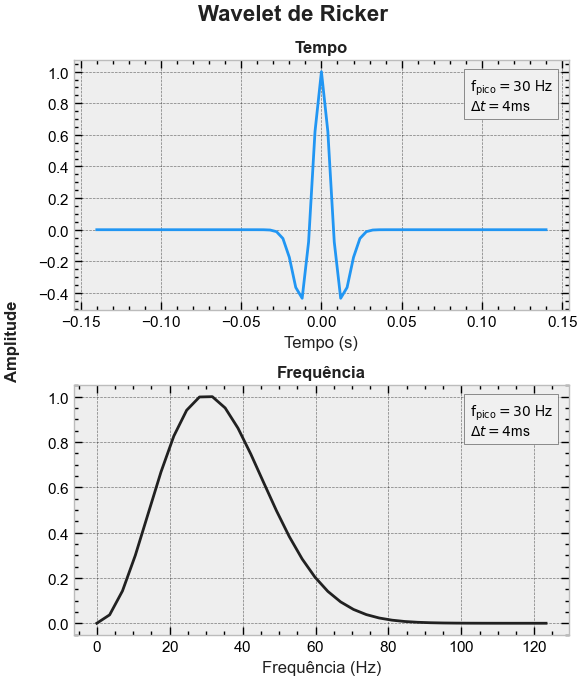

In [12]:
TEXT_COLOR = '#212121'

textstr1 = '\n'.join((
    r'$\text{f}_{\text{pico}}=%d$ Hz' % (pkfq),
    r'$\Delta t=%d$ms' % (dt)))

plt.rc('font', family='Arial')
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
fig.suptitle('Wavelet de Ricker', fontsize=16, fontweight='bold', color=TEXT_COLOR)
fig.supylabel('Amplitude', fontsize=12, fontweight='bold', color=TEXT_COLOR)

axs[0].plot(twlet,wlet, color='#2196f3')
axs[0].set_title('Tempo', fontweight='bold', fontsize=12, color=TEXT_COLOR)
axs[0].set_xlabel('Tempo (s)', fontsize=12, color=TEXT_COLOR)
axs[0].tick_params(axis='both', labelsize=11)
axs[0].text(0.80, 0.80, textstr1, transform=axs[0].transAxes,
            bbox=dict(facecolor='#f0f0f0', edgecolor='#616161'))

axs[1].plot(freqs, fft, color=TEXT_COLOR)
axs[1].set_title('Frequência', fontweight='bold', fontsize=12, color=TEXT_COLOR)
axs[1].set_xlabel('Frequência (Hz)', fontsize=12, color=TEXT_COLOR)
axs[1].tick_params(axis='both', labelsize=11)
axs[1].text(0.80, 0.80, textstr1, transform=axs[1].transAxes,
            bbox=dict(facecolor='#f0f0f0', edgecolor='#616161'))

plt.tight_layout()
plt.savefig('simposio_figs/wavelet_ricker.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# f(t) = (1 - )

## Butterworth

In [14]:
from scipy import signal

def butter_wavelet(freq_hi, freq_low, samples, dt):
    # Calculate time array
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Create impulse signal
    imp = signal.unit_impulse(t.shape[0], 'mid')

    # Apply high-pass Butterworth filter
    fs = 1000 * (1 / dt)
    b, a = signal.butter(4, freq_hi, fs=fs)
    response_zp = signal.filtfilt(b, a, imp)

    # Apply low-pass Butterworth filter
    low_b, low_a = signal.butter(2, freq_low, 'hp', fs=fs)
    butter_wvlt = signal.filtfilt(low_b, low_a, response_zp)

    return t, butter_wvlt

freqhi = 55
freqlow = 10
samplesb = 36
dtb = 4

twlet_b, wlet_b = butter_wavelet(freq_hi=freqhi, freq_low=freqlow,
                                 samples=samplesb, dt=dtb)          # wavelet
fft_b = abs(np.fft.rfft(wlet_b))
freqs_b = np.fft.rfftfreq(twlet_b.shape[0], d=4/1000)
fft_b = fft_b / np.max(fft_b)

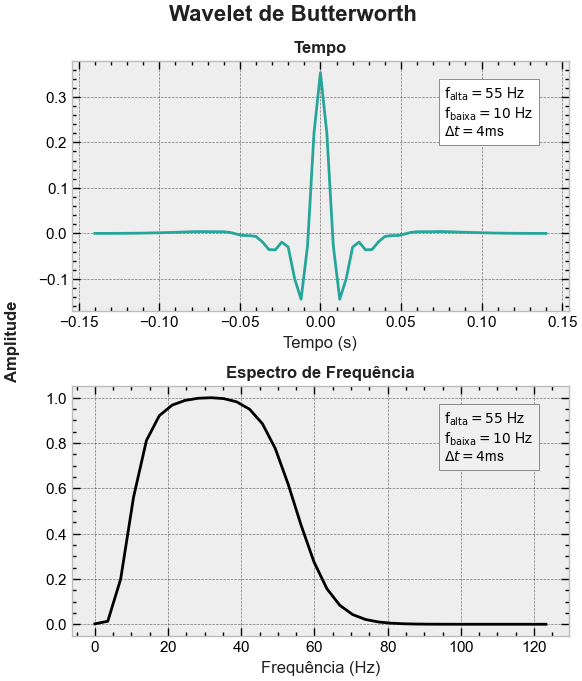

In [15]:
textstr2 = '\n'.join((
    r'$\text{f}_{\text{alta}}=%d$ Hz' % (freqhi),
    r'$\text{f}_{\text{baixa}}=%d$ Hz' % (freqlow),
    r'$\Delta t=%d$ms' % (dt)))

plt.rc('font', family='Arial')
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
fig.suptitle('Wavelet de Butterworth', fontsize=16, fontweight='bold', color=TEXT_COLOR)
fig.supylabel('Amplitude', fontsize=12, fontweight='bold', color=TEXT_COLOR)

axs[0].plot(twlet_b, wlet_b, color='#26a69a')
axs[0].set_title('Tempo', fontweight='bold', fontsize=12, color=TEXT_COLOR)
axs[0].set_xlabel('Tempo (s)', fontsize=12, color=TEXT_COLOR)
axs[0].tick_params(axis='both', labelsize=11)
axs[0].text(0.75, 0.70, textstr2, transform=axs[0].transAxes,
            bbox=dict(facecolor='white', edgecolor='#616161'))

axs[1].plot(freqs_b, fft_b, color="black")
axs[1].set_title('Espectro de Frequência', fontweight='bold', fontsize=12, color=TEXT_COLOR)
axs[1].set_xlabel('Frequência (Hz)', fontsize=12, color=TEXT_COLOR)
axs[1].tick_params(axis='both', labelsize=11)
axs[1].text(0.75, 0.70, textstr2, transform=axs[1].transAxes,
            bbox=dict(facecolor='#f0f0f0', edgecolor='#616161'))

plt.tight_layout()
plt.savefig('simposio_figs/wavelet_butterworth.png', dpi=300, bbox_inches='tight')
plt.show()

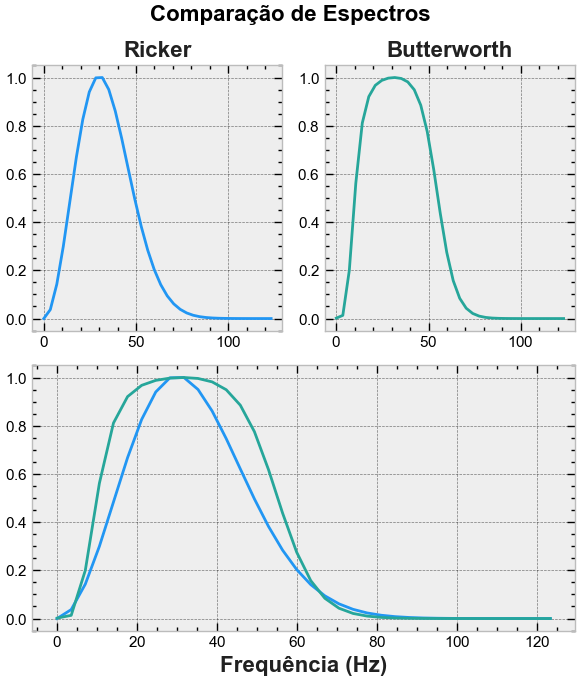

In [16]:
plt.figure(figsize=(6, 7))

plt.suptitle("Comparação de Espectros", fontsize=16, fontweight='bold')

plt.subplot2grid((2, 2), (0, 0))
plt.plot(freqs, fft, color="#2196f3")
plt.tick_params(axis='both', labelsize=11)
plt.title("Ricker", color=TEXT_COLOR, fontweight='bold')

plt.subplot2grid((2, 2), (0, 1))
plt.plot(freqs_b, fft_b, color="#26a69a")
plt.tick_params(axis='both', labelsize=11)
plt.title("Butterworth", color=TEXT_COLOR, fontweight='bold')

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis='both', labelsize=11)
plt.plot(freqs, fft, color="#2196f3")
plt.plot(freqs_b, fft_b, color="#26a69a")
plt.xlabel("Frequência (Hz)", color=TEXT_COLOR, fontweight='bold')

plt.tight_layout()
plt.savefig('simposio_figs/grid_wavelets.png', dpi=300, bbox_inches='tight')
plt.show()

# Inversão dos dados

Se está pegando o nz, nx e ny. Fazendo um desenho:
A inversão ocorrerá nas seções nz e nx, ao longo de ny.

<img src="Figures/schematic.png" width=600 height=400>

Então, cada operador PPop precisa ser aplicado em cada seção nz e nx, até o número de ny.

In [17]:
# Parâmetros do operador
nz, nx, ny = data_amp.shape

# Wavelet operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wlet/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

PPop_b = pylops.avo.poststack.PoststackLinearModelling(wlet_b/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

## Sem regularização

In [18]:
# Ricker
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_ricker = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section_r = data_amp[:, :, iy]
    impedance_section_r = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_section_ricker = \
        pylops.optimization.leastsquares.normal_equations_inversion(Op=PPop,
                                                                    y = seismic_section_r.flatten(),
                                                                    Regs=[],
                                                                    epsI=5e-1, #tikhonov
                                                                    x0 = impedance_section_r.flatten(), # modelo inicial
                                                                    engine='scipy',
                                                                    **dict(maxiter=1000))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_ricker[:, :, iy] = inverted_impedance_section_ricker.reshape(nz, nx)

inverted_impedance_final_ricker = inverted_impedance_ricker + imp_background
# Somando-se a impedância de baixa frequência com o modelo de baixa


# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance.npy', inverted_impedance)

In [19]:
# Butterworth
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_butter = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section_b = data_amp[:, :, iy]
    impedance_section_b = imp_background[:, :, iy]

    inverted_impedance_section_butter = \
        pylops.optimization.leastsquares.normal_equations_inversion(Op=PPop_b,
                                                                    y = seismic_section_b.flatten(),
                                                                    Regs=[],
                                                                    epsI=5e-1, #tikhonov
                                                                    x0 = impedance_section_b.flatten(), # modelo inicial
                                                                    engine='scipy',
                                                                    **dict(maxiter=1000))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_butter[:, :, iy] = inverted_impedance_section_butter.reshape(nz, nx)

inverted_impedance_final_butter = inverted_impedance_butter + imp_background
# Somando-se a impedância de baixa frequência com o modelo de baixa

# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance.npy', inverted_impedance)

In [20]:
residuo = inverted_impedance_final_ricker - inverted_impedance_final_butter
residuo1 = imp_30hz - inverted_impedance_final_ricker
residuo2 = imp_30hz - inverted_impedance_final_butter

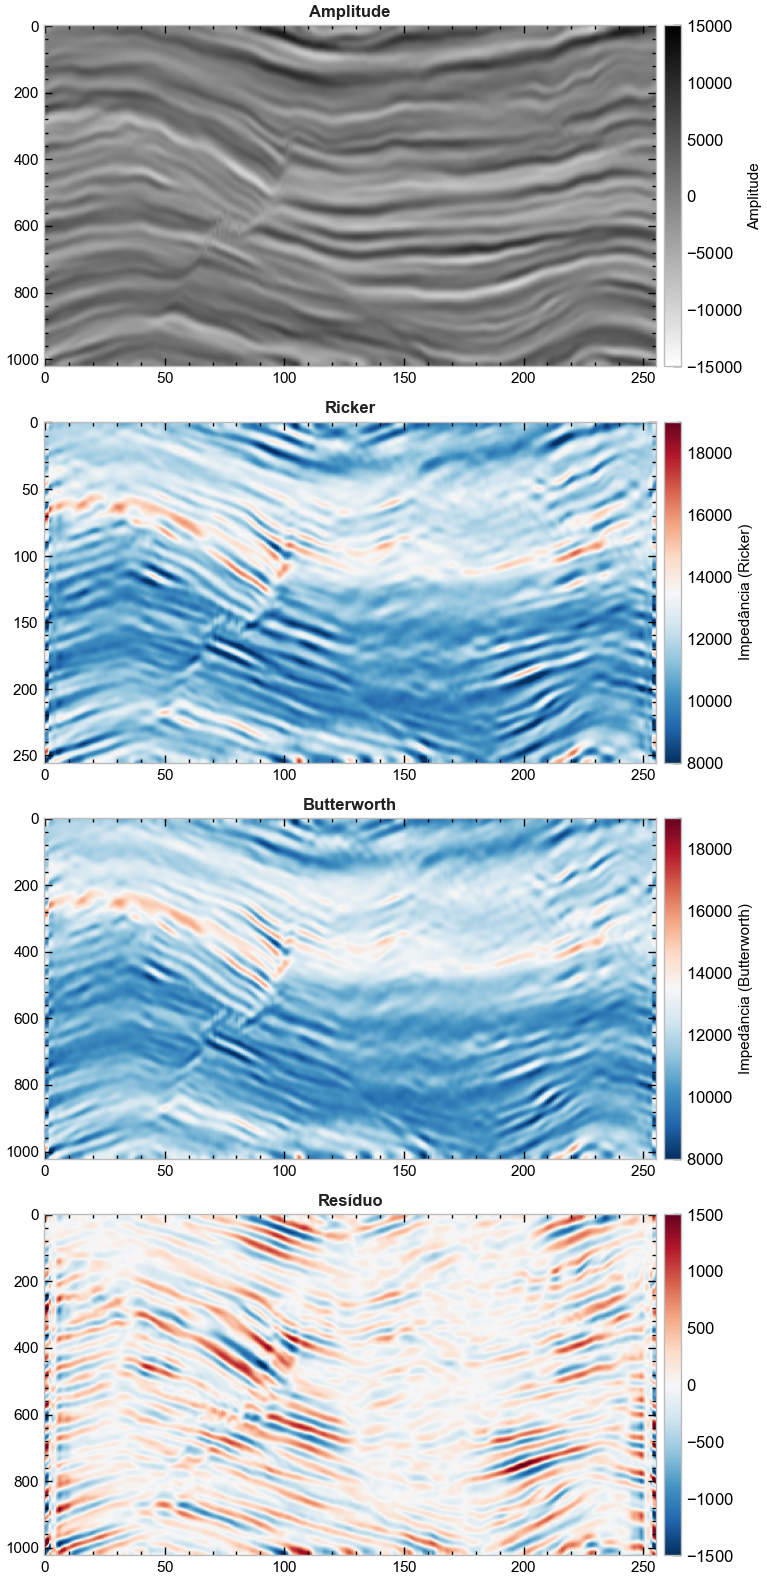

In [21]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

section = 128

plot1 = axs[0].imshow(data_amp[:,section,:].T,
           cmap='gray_r',
           aspect='auto',
           vmin=-15000,
           vmax=15000)
axs[0].set_title('Amplitude', fontsize=12, fontweight='bold', color=TEXT_COLOR)
axs[0].set_yticklabels([str(int(tick)*4) for tick in axs[0].get_yticks()])
axs[0].tick_params(axis='both', labelsize=11)
cbar1 = plt.colorbar(plot1, pad=0.01)
cbar1.set_label('Amplitude', size=11)
cbar1.ax.tick_params(labelsize=12)


plot2 = axs[1].imshow(inverted_impedance_final_ricker[:,section,:].T,
               cmap='RdBu_r',
               aspect='auto',
               vmin=8000,
               vmax=19000
               )
axs[1].set_title("Ricker", fontsize=12, fontweight='bold', color=TEXT_COLOR)
# axs[1].set_yticklabels([str(int(tick)*4) for tick in axs[1].get_yticks()])
axs[1].tick_params(axis='both', labelsize=11)
cbar2 = plt.colorbar(plot2, pad=0.01)
cbar2.set_label('Impedância (Ricker)', size=11)
cbar2.ax.tick_params(labelsize=12)

plot3 = axs[2].imshow(inverted_impedance_final_butter[:,section,:].T,
               cmap='RdBu_r',
               aspect='auto',
               vmin=8000,
               vmax=19000
               )
axs[2].set_title("Butterworth", fontsize=12, fontweight='bold', color=TEXT_COLOR)
axs[2].set_yticklabels([str(int(tick)*4) for tick in axs[2].get_yticks()])
axs[2].tick_params(axis='both', labelsize=11)
cbar = plt.colorbar(plot3, pad=0.01)
cbar.set_label('Impedância (Butterworth)', size=11)
cbar.ax.tick_params(labelsize=12)

plot4 = axs[3].imshow(residuo[:,section,:].T,
           cmap='RdBu_r',
           aspect='auto',
           vmin=-1500,
           vmax=1500)
axs[3].set_title('Resíduo', fontsize=12, fontweight='bold', color=TEXT_COLOR)
axs[3].set_yticklabels([str(int(tick)*4) for tick in axs[3].get_yticks()])
axs[3].tick_params(axis='both', labelsize=11)
cbar1 = plt.colorbar(plot4, pad=0.01)
cbar1.ax.tick_params(labelsize=12)


axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

plt.tight_layout()
plt.savefig('simposio_figs/inversao_impedancia.png', dpi=300, bbox_inches='tight')
plt.show()

Análise quantitativa do erro

In [22]:
ricker_inv = inverted_impedance_final_ricker
butter_inv = inverted_impedance_final_butter


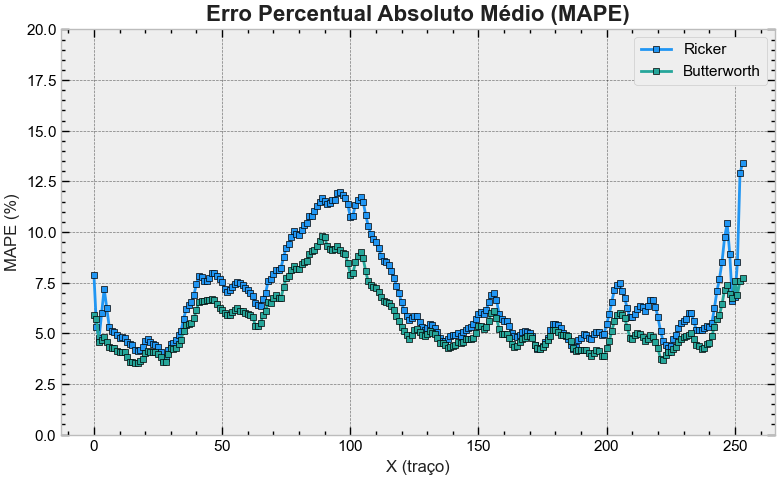

In [81]:
MAPE_r = np.zeros(nx)
MAPE_b = np.zeros(nx)


for ix in range(nx):
    MAPE_r[ix] = np.mean(np.abs( (ricker_inv[ix,128,:] - imp_30hz[ix,128,:]) / imp_30hz[ix,128,:] )) *100
    MAPE_b[ix] = np.mean(np.abs( (butter_inv[ix,128,:] - imp_30hz[ix,128,:]) / imp_30hz[ix,128,:] )) *100

MAPE_b = np.delete(MAPE_b, slice(0, 2))
MAPE_r = np.delete(MAPE_r, slice(0, 2))

plt.figure(figsize=(8, 5))
plt.plot(MAPE_r, 's-', label='Ricker', ms=5,
         color="#2196f3", markeredgecolor='black', markeredgewidth=0.5)
plt.plot(MAPE_b, 's-', label='Butterworth', ms=5,
         color="#26a69a", markeredgecolor='black', markeredgewidth=0.5)
plt.title('Erro Percentual Absoluto Médio (MAPE)', fontsize=16, fontweight='bold', color=TEXT_COLOR)
plt.xlabel('X (traço)', fontsize=12, color=TEXT_COLOR)
plt.ylabel('MAPE (%)', fontsize=12, color=TEXT_COLOR)
plt.tick_params(axis='both', labelsize=11)
plt.legend(loc='upper right', fontsize=11)
plt.ylim(0, 20)


plt.tight_layout()
plt.savefig('simposio_figs/mape.png', dpi=300, bbox_inches='tight')
plt.show()
# regiao de falha o erro é maior

In [40]:
MAPE_b = np.delete(MAPE_b, slice(0, 2))
MAPE_r = np.delete(MAPE_r, slice(0, 2))

In [41]:
print(f"A média do MAPE de Ricker é: {np.mean(MAPE_r):.2f}%")
print(f"A média do MAPE de Butterworth é: {np.mean(MAPE_b):.2f}%")

A média do MAPE de Ricker é: 6.67%
A média do MAPE de Butterworth é: 5.58%


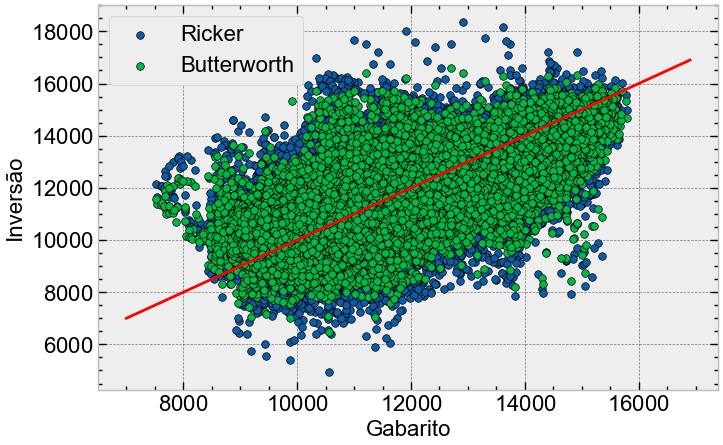

In [80]:
# iterar sobre o primeiro :, que é o x, x,y,z
plt.figure(figsize=(8, 5))

plt.scatter(imp_30hz[:,128,:].T,
            inverted_impedance_final_ricker[:,128,:].T,
            s=30,
            label='Ricker',
            edgecolors='black',
            linewidth=0.5)
plt.scatter(imp_30hz[:,128,:].T,
            inverted_impedance_final_butter[:,128,:].T,
            s=30,
            label='Butterworth',
            edgecolors='black',
            linewidth=0.5)
plt.ylabel('Inversão')
plt.xlabel('Gabarito')
plt.plot(x,x, color='red')
plt.legend(loc='upper left')
# abaixo da reta subestimando os valores de impedancia
# acima da reta superestimando os valores de impedancia

In [45]:
x = np.arange(7000, 17000, 100)

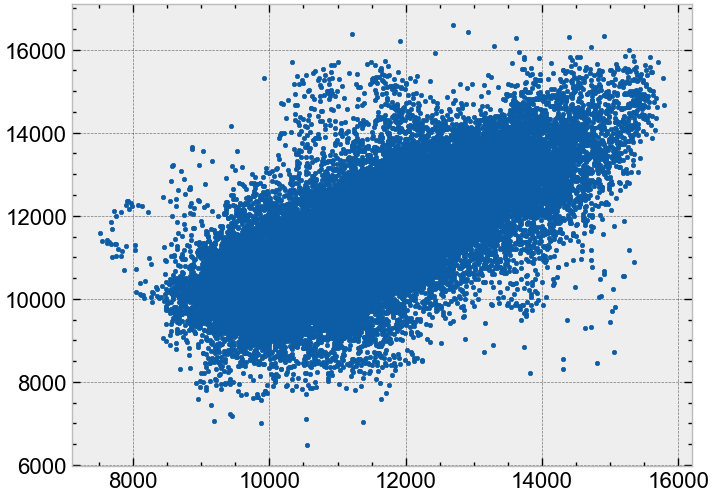

In [51]:
plt.scatter(imp_30hz[:,128,:].T, inverted_impedance_final_butter[:,128,:].T, label='Real', s=10)

In [87]:
plt.hist?

Signature:
plt.hist(
    x: 'ArrayLike | Sequence[ArrayLike]',
    bins: 'int | Sequence[float] | str | None' = None,
    range: 'tuple[float, float] | None' = None,
    density: 'bool' = False,
    weights: 'ArrayLike | None' = None,
    cumulative: 'bool | float' = False,
    bottom: 'ArrayLike | float | None' = None,
    histtype: "Literal['bar', 'barstacked', 'step', 'stepfilled']" = 'bar',
    align: "Literal['left', 'mid', 'right']" = 'mid',
    orientation: "Literal['vertical', 'horizontal']" = 'vertical',
    rwidth: 'float | None' = None,
    log: 'bool' = False,
    color: 'ColorType | Sequence[ColorType] | None' = None,
    label: 'str | Sequence[str] | None' = None,
    stacked: 'bool' = False,
    *,
    data=None,
    **kwargs,
) -> 'tuple[np.ndarray | list[np.ndarray], np.ndarray, BarContainer | Polygon | list[BarContainer | Polygon]]'
Docstring:
Compute and plot a histogram.

This method uses `numpy.histogram` to bin the data in *x* and count the
number of values in eac

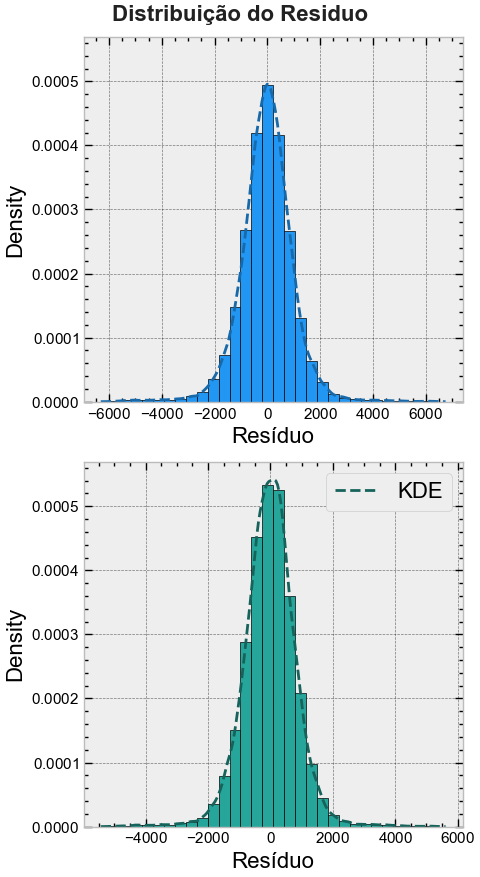

In [110]:
from tkinter import font
import seaborn as sns

# plt.figure(figsize=(6,5))
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(5, 9))
# Flatten the 3D array to 1D
residuo_flat_ricker = residuo1[section,:,:].flatten()
residuo_flat_butter = residuo2[section,:,:].flatten()

# Create a histogram for ricker
axs[0].hist(residuo_flat_ricker,
         bins=30,
         density=True,
         edgecolor='black',
         color='#2196f3')
axs[0].tick_params(axis='both', labelsize=11)
axs[0].set_xlabel('Resíduo')

# Create a KDE plot for ricker
sns.kdeplot(residuo_flat_ricker,
            color='#1769aa',
            linewidth=2,
            linestyle='--',
            label='KDE',
            ax=axs[0])  # Pass the second subplot axes

# Create a histogram for butter
axs[1].hist(residuo_flat_butter,
         bins=30,
         density=True,
         edgecolor='black',
         color='#26a69a')
axs[1].tick_params(axis='both', labelsize=11)
axs[1].set_xlabel('Resíduo')

# Create a KDE plot for butter
sns.kdeplot(residuo_flat_butter,
            color='#16635c',
            linewidth=2,
            linestyle='--',
            label='KDE',
            ax=axs[1])  # Pass the fourth subplot axes

# Set the title and labels


plt.suptitle('Distribuição do Residuo', fontsize=16, fontweight='bold', color=TEXT_COLOR)

plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool

# Output to notebook
output_notebook()

# Create a new plot with a title and axis labels
p = figure(title="MAPE plot", x_axis_label='ix', y_axis_label='MAPE',
           width=800, height=400,
           title_location="above",
           toolbar_location="below")

# Convert range to list
x_values = list(range(nx))

# Add a line renderer with legend and line thickness
line_r = p.line(x_values, MAPE_r, legend_label="MAPE - Ricker", line_width=2, color="red", alpha=0.8)
line_b = p.line(x_values, MAPE_b, legend_label="MAPE - Butterworth", line_width=2, color="blue", alpha=0.8)

# Add hover tool
hover = HoverTool(tooltips=[("ix", "$index"), ("Ricker", "@y"), ("Butterworth", "@y")],
                  renderers=[line_r, line_b])
p.add_tools(hover)

# Customize legend
p.legend.location = "top_right"
p.legend.click_policy="hide"

# Show the result
show(p)

Loading BokehJS ...

## Com regularização

In [ ]:
D2op = pylops.SecondDerivative([nz, nx], axis=1, dtype='float64')

In [ ]:

# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_regularized = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_regularized_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_regularized_section = \
        pylops.optimization.leastsquares.regularized_inversion(Op=PPop,
                                                               y = seismic_section.flatten(),
                                                               Regs=[D2op],
                                                               x0 = impedance_section.flatten(), # modelo inicial
                                                               **dict(damp=9e-1, iter_lim=1000, show=0))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_regularized[:, :, iy] = inverted_impedance_regularized_section.reshape(nz, nx)

# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance_regularized.npy', inverted_impedance_regularized)

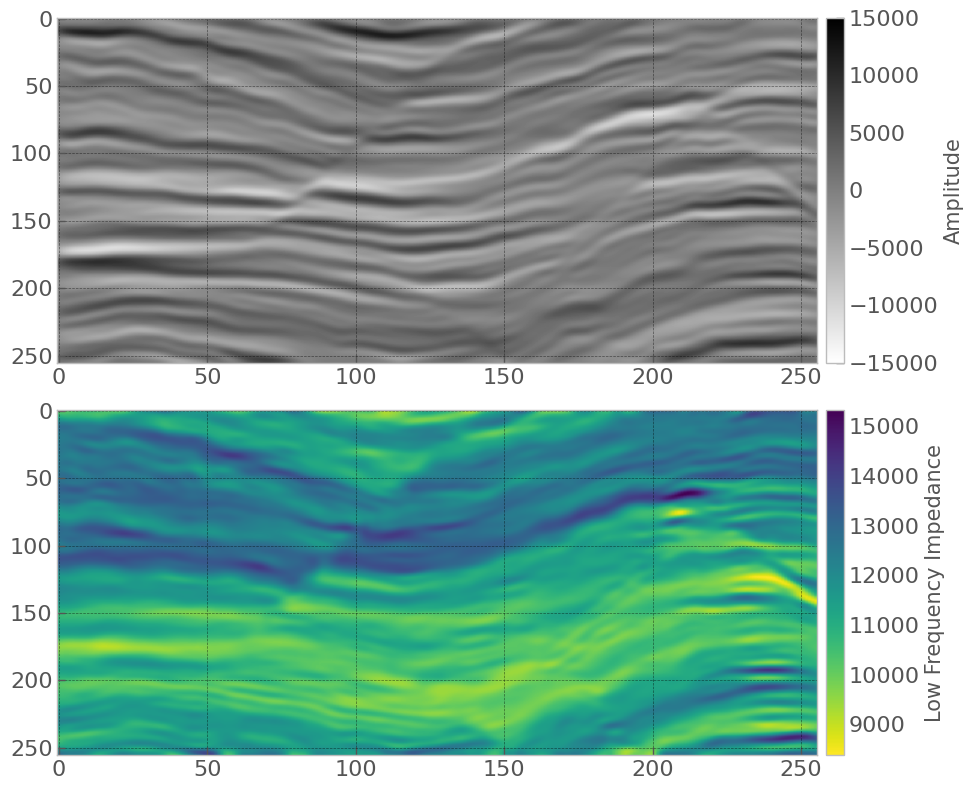

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(211)
c = plt.imshow(data_amp[150,:,:].T,
           cmap='gray_r',
           aspect='auto',
           vmin=-15000,
           vmax=15000)
plt.colorbar(c, pad=0.01).set_label('Amplitude', size=15)

plt.subplot(212)
c = plt.imshow(inverted_impedance_regularized[150,:,:].T,
               cmap='viridis_r',
               aspect='auto',
            #    vmin=5000,
            #    vmax=10000
               )
plt.colorbar(c, pad=0.01).set_label('Low Frequency Impedance', size=15)

plt.tight_layout()
plt.show()

## FISTA

In [ ]:
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_FISTA = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = data_imp[:, :, iy]

    inverted_impedance_FISTA_section = \
        pylops.optimization.sparsity.fista(Op=PPop,
                                           y = seismic_section.flatten(),
                                           x0 = impedance_section.flatten(), # modelo inicial
                                           niter=1000,
                                           eps=5-1,
                                           tol=1e-1)[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_FISTA[:, :, iy] = inverted_impedance_FISTA_section.reshape(nz, nx)

# Salvar o resultado da inversão (opcional)
#np.save('inverted_impedance_FISTA.npy', inverted_impedance_FISTA)

In [ ]:
# minimos quadrados sem regularização
plt.imshow(inverted_impedance_FISTA[25,:,:].T, aspect='auto', cmap='gray_r')
plt.colorbar()